In [5]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import importlib



from dataprepper import DataPrepper


In [6]:
CSV_TRAIN = "../Datasets/titanic_train.csv"
CSV_TEST = "../Datasets/titanic_test.csv"
assert Path(CSV_TRAIN).exists(), f"File not found: {CSV_TRAIN}"
assert Path(CSV_TEST).exists(), f"File not found: {CSV_TEST}"

train_set = pd.read_csv(CSV_TRAIN)
test_set = pd.read_csv(CSV_TEST)
data_prepper = DataPrepper("Titanic", "../Datasets/titanic_train.csv", "Survived")

In [7]:
target = "Survived"

feature_num_all = ["Age", "Fare"]
# feature_num_age = ["Age"]
feature_num_fare = ["Fare"]

feature_cat_all = ["Sex", "Pclass"]
feature_cat_pclass = ["Pclass"]
feature_cat_sex = ["Embarked"]

features = feature_num_fare + feature_cat_pclass + feature_cat_sex

X = train_set[features].copy()
y = train_set[target].astype(int).copy()

# From Part 1 we already know, that age has missing values and how to deal with it.
print("Missing values per column:\n", X.isna().sum(), "\n")

Missing values per column:
 Fare        0
Pclass      0
Embarked    2
dtype: int64 



In [8]:
# Numerical Features
num_pipeA = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

num_pipeF = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])


# Categorical
cat_pipeP = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(categories=[[1,2,3]], handle_unknown="use_encoded_value", unknown_value=-1))
])

cat_pipeS = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])


# Putting it all together (#TODO: discuss what we do with remainders)
preprocess = ColumnTransformer(
    transformers=[
        # ("age", num_pipeF, feature_num_age),
        ("fare", num_pipeF, feature_num_fare),
        ("sex", cat_pipeS, feature_cat_sex),
        ("pclass", cat_pipeP, feature_cat_pclass)
    ]
)

In [9]:
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline(steps=[
    ("pre", preprocess),
    ("clf", rf)
])

In [10]:
X = train_set.drop(columns="Survived")
y = train_set["Survived"]

X_trainT, X_test, y_trainT, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_trainT, y_trainT)

,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('fare', ...), ('sex', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [11]:
y_pred = pipe.predict(X_test)

              precision    recall  f1-score   support

           0       0.67      0.71      0.69       110
           1       0.48      0.43      0.46        69

    accuracy                           0.60       179
   macro avg       0.58      0.57      0.57       179
weighted avg       0.60      0.60      0.60       179

Accuracy: 0.6033519553072626


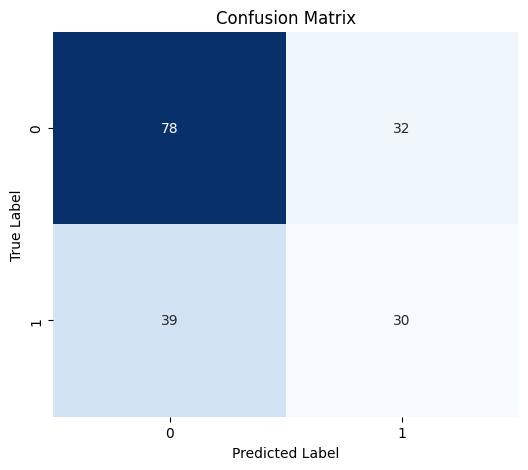

In [12]:
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

DataPrepper.evaluate_confusion(y_test=y_test, y_pred=y_pred)

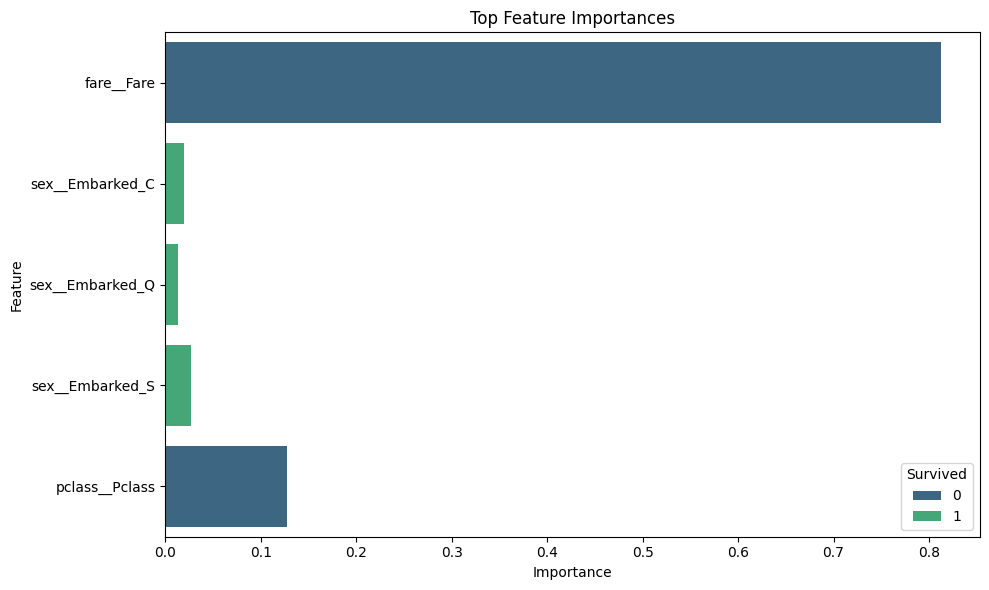

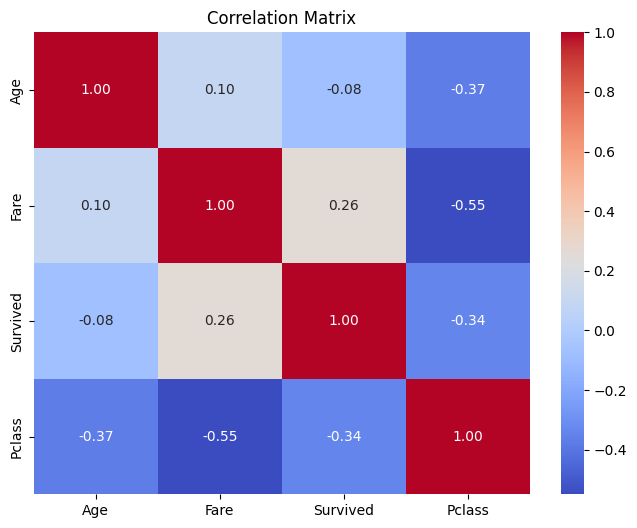

['Fare', 'Pclass', 'Embarked']


In [13]:
DataPrepper.evaluate_importance(pipe=pipe, steps=["pre", "clf"], y=y)

data_prepper.inspect_correlation(df=train_set, categories=["Age", "Fare", "Survived", "Pclass"])

print(features)